# Compare Lamoreux & Janaf thermodynamic tables
- validate general agreement between Lamoreux & JANAF tables

In [1]:
import vaporock

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
from thermoengine import model

/opt/conda/lib/python3.9/site-packages/thermoengine/calibrate.py:378: DeprecationWarning: invalid escape sequence \*
  [re.match(base+'[\*0-9]*', iname) is not None
/opt/conda/lib/python3.9/site-packages/thermoengine/calibrate.py:382: DeprecationWarning: invalid escape sequence \*
  [re.match(base+'\*', iname) is not None
/opt/conda/lib/python3.9/site-packages/thermoengine/equilibrate.py:4014: DeprecationWarning: invalid escape sequence \*
  """Sets the bulk composition of the system


In [2]:
T = np.linspace(298, 2500, 101)

In [3]:
vapor = vaporock.Vapor()

In [4]:
display(vapor.melt_comps.head())
display(vapor.species_comps.head())
display(vapor.rxn_coefs.head())
display(vapor.atom_mass)

O  Mg  Ca  Al  Si  Na  K  Fe
O2     2   0   0   0   0   0  0   0
MgO    1   1   0   0   0   0  0   0
CaO    1   0   1   0   0   0  0   0
Al2O3  3   0   0   2   0   0  0   0
SiO2   2   0   0   0   1   0  0   0

O  Mg  Ca  Al  Si  Na  K  Fe
species_name                              
O             1   0   0   0   0   0  0   0
Mg(g)         0   1   0   0   0   0  0   0
MgO(g)        1   1   0   0   0   0  0   0
Mg2(g)        0   2   0   0   0   0  0   0
Ca(g)         0   0   1   0   0   0  0   0

O2  MgO  CaO  Al2O3  SiO2  Na2O  K2O  FeO
species_name                                            
O             0.5  0.0  0.0    0.0   0.0   0.0  0.0  0.0
Mg(g)        -0.5  1.0  0.0    0.0   0.0   0.0  0.0  0.0
MgO(g)        0.0  1.0  0.0    0.0   0.0   0.0  0.0  0.0
Mg2(g)       -1.0  2.0  0.0    0.0   0.0   0.0  0.0  0.0
Ca(g)        -0.5  0.0  1.0    0.0   0.0   0.0  0.0  0.0

O     16.000
Mg    24.305
Ca    40.078
Al    26.982
Si    28.085
Na    22.990
K     39.098
Fe    55.845
dtype: float64

In [5]:
G_gas_species, G_O2 = vapor.eval_gibbs_species(T)
# G_gas_species.head()

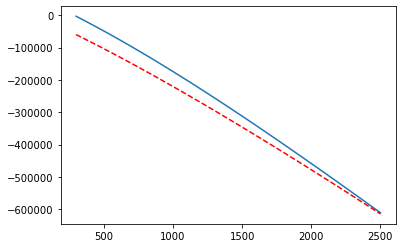

In [6]:
plt.figure()
plt.plot(T, G_gas_species.loc['MgO(g)'], '-')
plt.plot(T, G_O2, 'r--')

In [7]:
Fe_dat = pd.read_excel('data/Fe-JANAF-data.xlsx', index_col='species_name')

In [8]:
# janaf_dat = pd.read_excel('data/JANAF-data.xlsx', index_col='species_name',
#                          sheet_name='gas-phases')
janaf_dat = pd.read_csv('data/JANAF-vapor-data.csv', index_col='species_name')

In [9]:
janaf_coefs = ['A','B','C','D','E','F','G','H']

In [10]:
Fe_coefs = Fe_dat.loc['Fe(g)',janaf_coefs]
FeO_coefs = Fe_dat.loc['FeO(g)',janaf_coefs]
Mg_T1_coefs = Fe_dat.loc['Mg(g)_T1',janaf_coefs]
Mg_T2_coefs = Fe_dat.loc['Mg(g)_T2',janaf_coefs]
Mg_s_coefs = Fe_dat.loc['Mg(s)',janaf_coefs]
Mg_l_coefs = Fe_dat.loc['Mg(l)',janaf_coefs]

K_coefs = janaf_dat.loc['K(g)', janaf_coefs]
K_T1_coefs = K_coefs.iloc[0]
K_T2_coefs = K_coefs.iloc[1]

In [11]:
def janaf_dH(T, coefs):
    t = T/1e3
    dH = (coefs['A']*t + coefs['B']/2*t**2 +coefs['C']/3*t**3 
          + coefs['D']/4*t**4 - coefs['E']/t)
    dH += coefs['F']
    # dH -= coefs['H']
    dH *= 1e3
    # J/mol
    return dH
    
def janaf_S(T, coefs):
    t = T/1e3
    S = (coefs['A']*np.log(t) + coefs['B']*t + coefs['C']/2*t**2 
          + coefs['D']/3*t**3 - coefs['E']/2/t**2)
    S += coefs['G']
    
    # J/mol/K
    return S

def janaf_G(T, coefs):
    dH = janaf_dH(T, coefs)
    S = janaf_S(T, coefs)
    G = dH - T*S
    return G

In [12]:
T = np.linspace(298, 2500, 101)
G_Fe_janaf = janaf_G(T, Fe_coefs)
G_FeO_janaf = janaf_G(T, FeO_coefs)

G_Mg_T1_janaf = janaf_G(T, Mg_T1_coefs)
G_Mg_T2_janaf = janaf_G(T, Mg_T2_coefs)
G_Mg_s_janaf = janaf_G(T, Mg_s_coefs)
G_Mg_l_janaf = janaf_G(T, Mg_l_coefs)

G_K_T1_janaf = janaf_G(T, K_T1_coefs)
G_K_T2_janaf = janaf_G(T, K_T2_coefs)

# G_gas_species, G_O2 = eval_vapor_gibbs_species(T, vapor_dat, O2_dat)
# G_gas_species

(-2.0, 2.0)

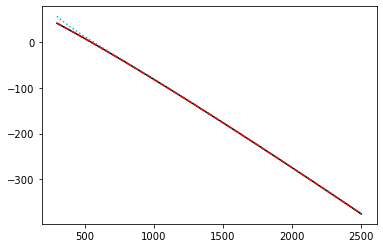

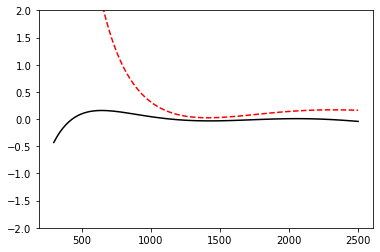

In [13]:
plt.figure()
plt.plot(T, G_K_T1_janaf/1e3, 'k-')
plt.plot(T, G_K_T2_janaf/1e3, 'c:')

plt.plot(T, G_gas_species.loc['K(g)']/1e3, 'r--')

plt.figure()
plt.plot(T, (G_K_T1_janaf-G_gas_species.loc['K(g)'])/1e3, 'k-')
plt.plot(T, (G_K_T2_janaf-G_gas_species.loc['K(g)'])/1e3, 'r--')
plt.ylim(-2,2)





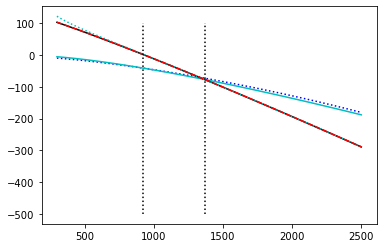

In [14]:
plt.figure()
plt.plot(T, G_Mg_s_janaf/1e3, 'b:')
plt.plot(T, G_Mg_l_janaf/1e3, 'c-')
plt.plot(T, G_Mg_T1_janaf/1e3, 'k-')
plt.plot(T, G_Mg_T2_janaf/1e3, 'c:')

plt.plot(T, G_gas_species.loc['Mg(g)']/1e3, 'r--')
Tvap = 1366.104
Tmelt = 923
plt.plot([Tvap,Tvap],[-500,+100], 'k:')
plt.plot([Tmelt,Tmelt],[-500,+100], 'k:')




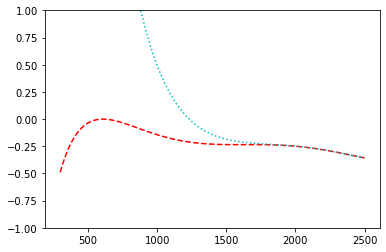

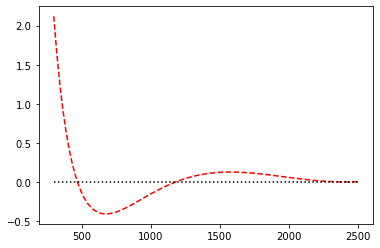

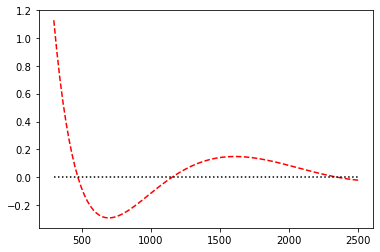

In [15]:
plt.figure()
plt.plot(T, (G_Mg_T1_janaf-G_gas_species.loc['Mg(g)'])/1e3, 'r--')
plt.plot(T, (G_Mg_T2_janaf-G_gas_species.loc['Mg(g)'])/1e3, 'c:')
plt.ylim(-1,1)



plt.figure()
# plt.plot(T, G_Fe_janaf, 'k-')
plt.plot(T, (G_gas_species.loc['Fe(g)'] - G_Fe_janaf)/1e3, 'r--')
plt.plot(T, 0*T, 'k:')

plt.figure()
# plt.plot(T, G_FeO_janaf, 'k-')
plt.plot(T, (G_gas_species.loc['FeO(g)']-G_FeO_janaf)/1e3, 'r--')
plt.plot(T, 0*T, 'k:')
